In [1]:
from inspect_results import *
import inspect_results
import matplotlib as plt
import json

usage: ipykernel_launcher.py [-h] [--run RUN [RUN ...]] [--group] [--table]
                             [--bar] [--scatter] [--old]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/lmm/.local/share/jupyter/runtime/kernel-v3213a295b421bd3dc05da96f0afa87c847c1e1879.json


['trapped-mawile_gpt-4o-mini.json']
{'NetExec',
 'R2R',
 'Real-ESRGAN',
 'Torch-Pruning',
 'X-AnyLabeling',
 'aim',
 'black',
 'boto3',
 'cloud-custodian',
 'core',
 'django-stubs',
 'dlt',
 'fastapi',
 'icloud-drive-docker',
 'instructor',
 'keyboard',
 'modelscope',
 'moto',
 'nonebot2',
 'numba',
 'open-interpreter',
 'opencompass',
 'openpilot',
 'proxy_pool',
 'rich',
 'sabnzbd',
 'sherlock',
 'spaCy',
 'speechbrain',
 'spleeter',
 'textual',
 'thefuck',
 'tqdm',
 'warehouse',
 'you-get'}
### trapped-mawile:
36


In [2]:
def get_results(runs):
    runs_dir = "logs/eval"
    contents = os.listdir(runs_dir)
    run_paths = []
    for run in runs:
        run_paths.extend([run_path for run_path in contents if run in run_path])
    print(run_paths)
    data = []
    for run_path in run_paths:
        with open(os.path.join(runs_dir, run_path), "r") as f:

            data.extend(json.load(f))


In [3]:
# run = 'slimmer-kabuto'
# run = 'trapped-mawile'
run = 'pulled-dugtrio'
res = json.load(open(f'logs/eval/{run}_gpt-4o-mini.json', 'r'))
run_dir = run_dir = f"figs/{run}"
inspect_results.run_dir = run_dir
os.makedirs(run_dir, exist_ok=True)

In [4]:
flat_res = [(key, val) for round in res for key, val in round.items() if 'build_status' in val]
res_repos = set([r[0] for r in flat_res])

In [5]:
repos_dir = 'eval/resources'
repo_paths = [os.path.join(repos_dir, r) for r in [
    "python_repos_5k-1k.json",
    "python_repos_10k-5k.json",
    "python_repos_20k-10k.json",
    "python_repos_20k+.json",
]]
repos = []
for path in repo_paths:
    repos.extend(json.load(open(path, 'r')))
repos = {r['url'].split('/')[-1][:-4]: r for r in repos}

In [6]:
(set([tags for repo in repos.values() for tags in repo['tags']]))

{'bash-extra',
 'install-other',
 'install-pytest',
 'install-self',
 'install-tox',
 'make-install',
 'make-test',
 'pip-extra',
 'poetry',
 'poetry-extra',
 'pytest',
 'pytest-extra',
 'requirements',
 'requirements-extra',
 'test-other',
 'tox',
 'unittest'}

In [7]:
valid_repos = set(res_repos).intersection(set(repos.keys()))
res_by_repos = {repo: [r[1] for r in flat_res if r[0] == repo] for repo in valid_repos}

print(len(valid_repos))

40


In [8]:
results = {
    repo: {
        'recall': sum([r['recall'] for r in rr]) / len(rr),
        'precision': (sum([r['recall'] * len(r['relevant']) / len(r['retrieved']) for r in rr if len(r['retrieved']) > 0]) / len(rr)),
        'build_rate': (len([r for r in rr if r['build_status'] == 'success'])) / len(rr),
        'info': repos[repo]['info'],
        'visibility': repos[repo]['visibility'],
        'tags': repos[repo]['tags']
    }
    for repo, rr in res_by_repos.items()
}
info_results = {key: val for key, val in results.items() if val['info'] >= 0}
buildable_results = {key: val for key, val in info_results.items() if val['build_rate'] > 0} 



In [21]:
print(run_dir)

figs/pulled-dugtrio-buildable


In [25]:
run_dir = run_dir + "-buildable"
inspect_results.run_dir = run_dir

b_results = {key: val for key, val in results.items() if val['build_rate'] > 0} 

In [10]:
def group_by_tags(results, tags: List[List[str]]):
    ret = [[r for r in results.values() if any(t in r['tags'] for t in tag)] for tag in tags]
    ret.append([r for r in results.values() if not any([any(t in r['tags'] for t in tag) for tag in tags])])
    return ret

In [11]:
print(results['aim']['recall'])
print(len(res_by_repos['aim']))
print(sum([r['recall'] for r in res_by_repos['aim']]))

1.0
10
10.0


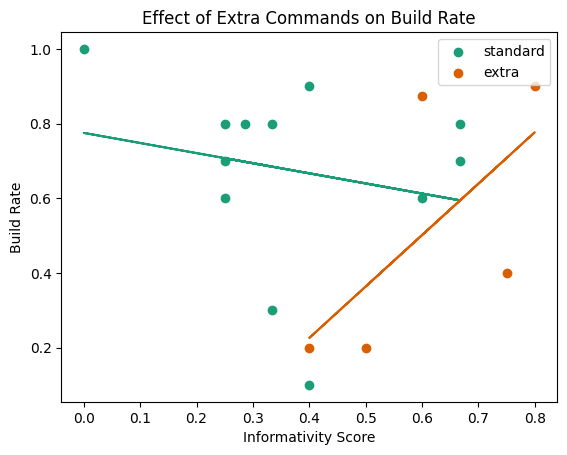

In [27]:
extra_groups = [['extra', 'pip-extra', 'requirements-extra', 'poetry-extra', 'pytest-extra', 'bash-extra']]
extra_grouped_repos = group_by_tags(buildable_results, extra_groups)
multi_scatter(
    reversed([[r['info'] for r in res] for res in extra_grouped_repos]),
    reversed([[r['build_rate'] for r in res] for res in extra_grouped_repos]),
    reversed([res[0] for res in extra_groups] + ['standard']),
    "Informativity Score",
    "Build Rate",
    "Effect of Extra Commands on Build Rate",
    lobf=True

)

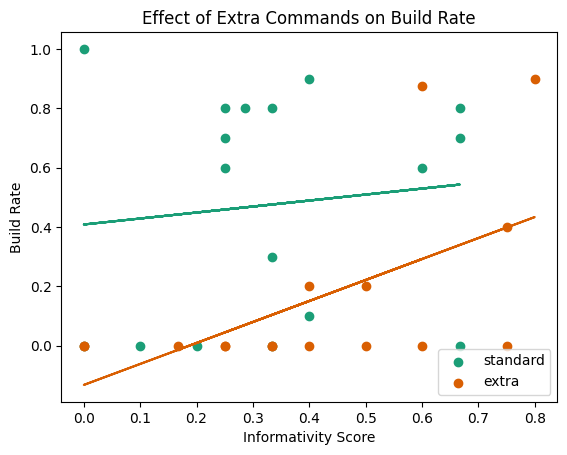

In [24]:
extra_groups = [['extra', 'pip-extra', 'requirements-extra', 'poetry-extra', 'pytest-extra', 'bash-extra']]
extra_grouped_repos = group_by_tags(info_results, extra_groups)
multi_scatter(
    reversed([[r['info'] for r in res] for res in extra_grouped_repos]),
    reversed([[r['build_rate'] for r in res] for res in extra_grouped_repos]),
    reversed([res[0] for res in extra_groups] + ['standard']),
    "Informativity Score",
    "Build Rate",
    "Effect of Extra Commands on Build Rate",
    lobf=True

)

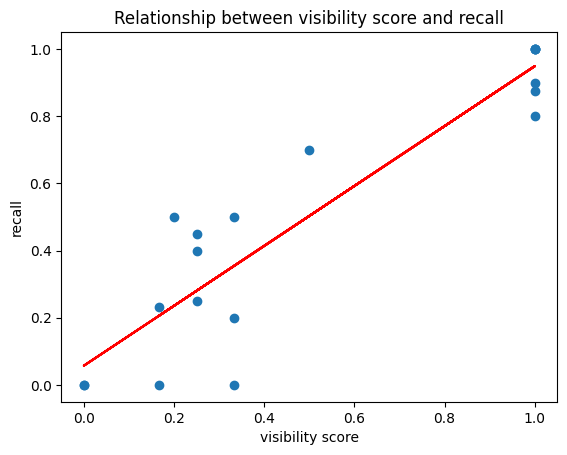

In [28]:
scatter(
    [r['visibility'] for r in b_results.values()],
    [r['recall'] for r in b_results.values()],
    "visibility score",
    "recall",
    "Relationship between visibility score and recall"
)

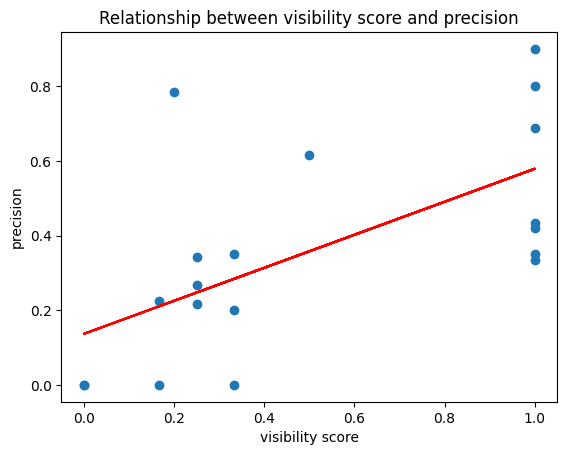

In [29]:
scatter(
    [r['visibility'] for r in b_results.values()],
    [r['precision'] for r in b_results.values()],
    "visibility score",
    "precision",
    "Relationship between visibility score and precision"
)

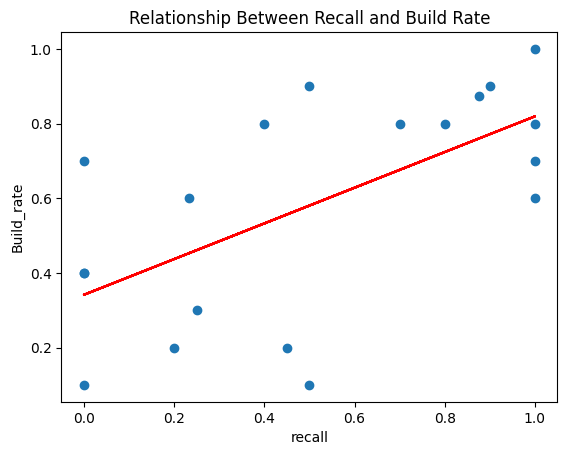

In [30]:
scatter(
    [r['recall'] for r in b_results.values()],
    [r['build_rate'] for r in b_results.values()],
    'recall',
    'Build_rate',
    "Relationship Between Recall and Build Rate"
)

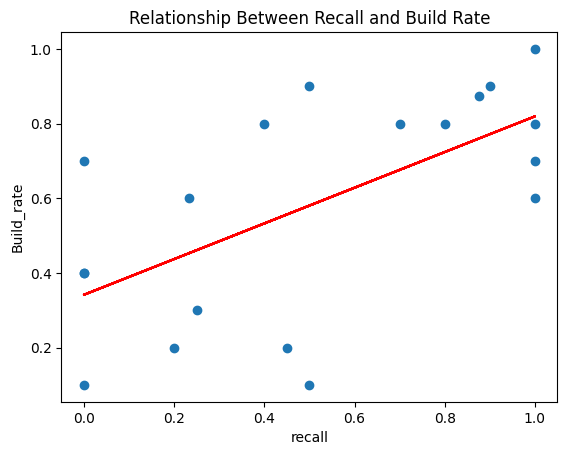

In [ ]:
scatter(
    [r['recall'] for r in b_results.values()],
    [r['build_rate'] for r in b_results.values()],
    'recall',
    'Build_rate',
    "Relationship Between Recall and Build Rate"
)

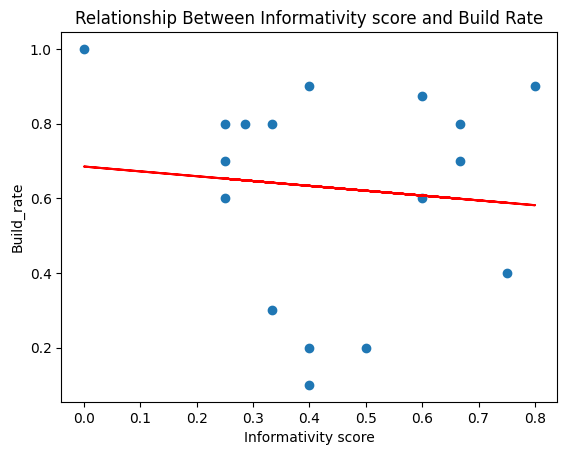

In [31]:
extra_groups = [['requirements', 'requirements-extra'], ['poetry']]
extra_grouped_repos = group_by_tags(info_results, extra_groups)
multi_scatter(
    reversed([[r['info'] for r in res] for res in extra_grouped_repos]),
    reversed([[r['build_rate'] for r in res] for res in extra_grouped_repos]),
    reversed([res[0] for res in extra_groups] + ['standard']),
    "Informativity Score",
    "Build Rate",
    "Effect of Extra Commands on Build Rate",
    lobf=True

)

scatter(
    [r['info'] for r in buildable_results.values()],
    [r['build_rate'] for r in buildable_results.values()],
    'Informativity score',
    'Build_rate',
    "Relationship Between Informativity score and Build Rate"
)